# Genome-wide selection scane (GWS) using the population branching statistic (PBS)

This notebook illustrates an analysis that uses genetic variation data and scans the genome for evidence of positive selection in a specific population. The analysis is illustrated using scikit-allel and the Ag1000G phase 2 dataset.

In [1]:
import numpy as np
import dask.array as da
import allel
import intake
import matplotlib.pyplot as plt
%matplotlib inline

## Cluster setup

In [ ]:
# replace with different setup if using a different dask scheduler
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster(n_workers=10)
client = Client(cluster)
client

## Data setup

In [3]:
# open malariagen data catalog for accessing data on google cloud
cat = intake.open_catalog('https://malariagen.github.io/intake/gcs.yml')

In [4]:
# Anopheles gambiae 1000 genomes phase 2
list(cat.ag2)

['samples', 'snps', 'snps_pass', 'snps_pass_biallelic', 'haps']

In [5]:
# here are the SNP genotype data in scikit-allel-style zarr format
callset = cat.ag2.snps_pass.to_zarr()
callset

<zarr.hierarchy.Group '/' read-only>

In [6]:
# data are grouped first by chromosome - 2L, 2R, 3L, 3R are the autosomes of Anopheles gambiae
print(callset.tree(level=1))

/
 ├── 2L
 ├── 2R
 ├── 3L
 ├── 3R
 ├── X
 └── samples (1142,) object


In [7]:
# within each chromosome group (e.g., 3R), data look like this
print(callset['3R'].tree())

3R
 ├── calldata
 │   └── GT (14481509, 1142, 2) int8
 ├── samples (1142,) object
 └── variants
     ├── ABHet (14481509,) float32
     ├── ABHom (14481509,) float32
     ├── AC (14481509, 3) int32
     ├── AF (14481509, 3) float32
     ├── ALT (14481509, 3) |S1
     ├── AN (14481509,) int32
     ├── Accessible (14481509,) bool
     ├── BaseCounts (14481509, 4) int32
     ├── BaseQRankSum (14481509,) float32
     ├── Coverage (14481509,) int32
     ├── CoverageMQ0 (14481509,) int32
     ├── DP (14481509,) int32
     ├── DS (14481509,) bool
     ├── Dels (14481509,) float32
     ├── FILTER_BaseQRankSum (14481509,) bool
     ├── FILTER_FS (14481509,) bool
     ├── FILTER_HRun (14481509,) bool
     ├── FILTER_HighCoverage (14481509,) bool
     ├── FILTER_HighMQ0 (14481509,) bool
     ├── FILTER_LowCoverage (14481509,) bool
     ├── FILTER_LowMQ (14481509,) bool
     ├── FILTER_LowQual (14481509,) bool
     ├── FILTER_NoCoverage (14481509,) bool
     ├── FILTER_PASS (14481509,) bool
     ├

In [8]:
# inspect genotype calls from a single chromosome arm (e.g., 3R) - the genotype calls are the main data we operate on
gt = allel.GenotypeDaskArray(callset['3R/calldata/GT'])
gt

<GenotypeDaskArray shape=(14481509, 1142, 2) dtype=int8>

In [9]:
# load sample metadata - each row has data on an individual mosquito
df_samples = cat.ag2.samples.read()
df_samples.head()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


## Illustration of some key steps

Before showing the full PBS analysis, first illustrate some key steps that prepare and compute the input data.

To prepare the data, we need to be able to subset to variants that pass pre-defined filters, and to samples in a given population.

### Locate pass variants

In [10]:
# e.g., for chromosome 3R
loc_pass_variants = callset['3R/variants/FILTER_PASS'][:]
loc_pass_variants

array([ True,  True,  True, ...,  True,  True,  True])

In [11]:
np.count_nonzero(loc_pass_variants)

14481509

### Locate samples in population

In [12]:
# e.g., the Anopheles gambiae mosquitoes from Burkina Faso
pop = 'BFgam'

In [13]:
loc_pop_samples = df_samples[df_samples.population == pop].index.values
loc_pop_samples

array([ 67,  81,  82,  83,  91,  92,  93,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 155, 156, 157, 158, 159, 160,
       161, 163, 164, 165, 166, 169, 173, 174, 182, 184, 185, 186, 188,
       189, 191, 192, 194, 197, 203, 204, 205, 206, 207, 210, 211, 214,
       215, 218, 219, 220, 221, 222, 223, 224, 226, 227, 229, 230, 232,
       233])

In [14]:
len(loc_pop_samples)

92

In [15]:
# select rows and columns from the genotype calls array
gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
gt_pass_pop

<GenotypeDaskArray shape=(14481509, 92, 2) dtype=int8>

### Allele count computation

In [16]:
# The PBS test is based on comparisons of different populations. 
# To compare populations, we perform an allele count within each population. 
# This step is data-intensive because it makes a pass over the genotype calls
# array.
# This step is not compute-intensive.
# This is a good step to watch the dask dashboard.
# E.g.:
ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3).compute()
ac_pass_pop

<AlleleCountsArray shape=(14481509, 4) dtype=int32>
184   0   0   0
184   0   0   0
184   0   0   0
...
184   0   0   0
180   4   0   0
184   0   0   0

In [17]:
# how many segregating SNPs?
ac_pass_pop.count_segregating()

6022557

## PBS multi-population genome-wide scan for signals of selection

Now we illustrate the full PBS analysis, which we want to be able to run for any chromosome and any set of three populations.

In [18]:
def population_allele_counts(chrom, pop):
    """Convenience function to obtain allele counts for a given chromosome and population."""
    gtz = callset[chrom]['calldata/GT']
    gt = allel.GenotypeDaskArray(gtz)
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    loc_pop_samples = df_samples[df_samples.population == pop].index.values
    print(pop, 'no. samples:', len(loc_pop_samples))
    gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
    ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3)
    return ac_pass_pop


def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    """Compute the PBS statistic in windows across the genome."""
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # compute allele counts in each population
    ac1 = population_allele_counts(chrom, pop1)
    ac2 = population_allele_counts(chrom, pop2)
    ac3 = population_allele_counts(chrom, pop3)
    ac1, ac2, ac3 = da.compute(ac1, ac2, ac3)
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    ac3 = allel.AlleleCountsArray(ac3)
    print('finished allele counting')

    # locate and subset to segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = ac.is_biallelic_01() & (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    print('found', np.count_nonzero(loc_seg), 'segregating variants')
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    print('finished locating segregating variants')
    
    # setup windows over the genome
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs in windows
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)
    print('finished computing PBS')

    # Visualise the results - a peak indicates a genome location under selection
    # in the first population.
    fig, ax = plt.subplots(figsize=(14, 3), facecolor='w')
    x = (starts + ends) / 2
    ax.plot(x, res, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_title(f'Signals of selection in {pop1} (reference populations: {pop2}, {pop3})')
    ax.set_xlabel(f'Chromosome {chrom} position (Mbp)')
    ax.set_xticklabels(np.array(ax.get_xticks()) / 1e6)
    ax.set_ylabel('PBS')


BFgam no. samples: 92
UGgam no. samples: 112
GW no. samples: 91
finished allele counting
found 1431465 segregating variants
finished locating segregating variants
finished computing PBS


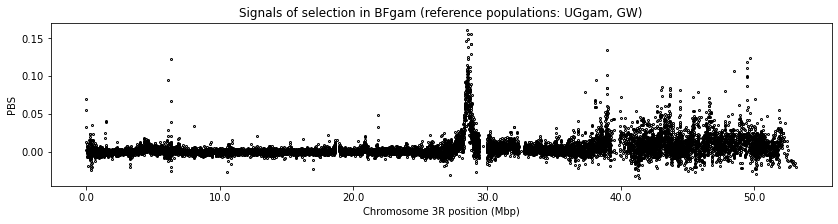

In [19]:
# Here, for example, we perform the scan over chromosome 3R, using 
# populations from Burkina Faso (BFgam), Uganda (UGgam) and Guinea-Bissau.
# This is a good step to watch the Dask dashboard:
pbs('3R', 'BFgam', 'UGgam', 'GW')

BFgam no. samples: 92
UGgam no. samples: 112
GW no. samples: 91
finished allele counting
found 1818277 segregating variants
finished locating segregating variants
finished computing PBS


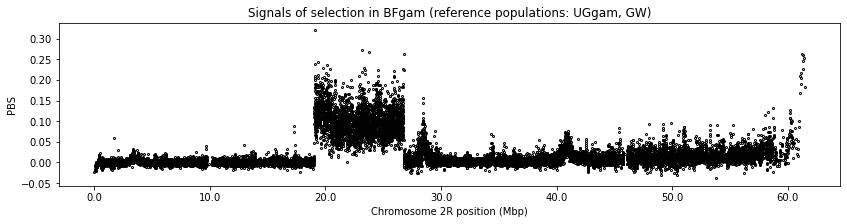

In [20]:
# Here's a scan using the same populations but on a different chromosome:
pbs('2R', 'BFgam', 'UGgam', 'GW')

In [ ]:
# Here's a scan using different populations:
pbs('X', 'BFcol', 'AOcol', 'GW')

BFcol no. samples: 75
AOcol no. samples: 78
GW no. samples: 91
finished allele counting
found 436137 segregating variants
finished locating segregating variants
